# **UNet Segmentation TEST (inference)**
### *Keras / Tensorflow 2*


### This notebook is a remake from Thomas Grenier's original segmentation lab notebook
#### You may use this notebook to import and test models saved in "trained_model" directory

*thomas.grenier@creatis.insa-lyon.fr*

## <span style="color:brown"> **1- System setting**

We start by loading necessary libraries and setting variables.
Some of them are related to data.
But, to ensure that the code works on almost all infrastructures, low-level system variable are also initialized. 

In [1]:
!pip install medpy
!pip install tqdm
!pip install opencv-python

In [2]:
import glob
import os
import sys
from datetime import datetime

from tqdm import tqdm 

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,8)

import cv2
import tensorflow as tf

if 'model' in locals(): 
    print("deleting model")
    del model    
    
# select the device (CPU or GPU) to run on
num_CPU = 1
num_cores = 4

# KERNEL msut be restarted if you change GPU 0 -> 1 or 1 -> 0 (cannot change runtime after initialization)
GPU = 1  # GPU = 0 => CPU Only ; GPU = 1 => use GPU

physical_gpu_devices = tf.config.list_physical_devices('GPU')
physical_cpu_devices = tf.config.list_physical_devices('CPU')
print(physical_gpu_devices)
print(physical_cpu_devices)

if GPU:
    tf.config.set_visible_devices(physical_gpu_devices[0], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    print(visible_devices)  
    for device in visible_devices:
        print(device)
    tf.config.threading.set_intra_op_parallelism_threads(num_CPU)
    tf.config.threading.set_inter_op_parallelism_threads(num_cores) 
else:
    try:
      # Disable all GPUS
      tf.config.set_visible_devices([], 'GPU')
      visible_devices = tf.config.get_visible_devices()
      for device in visible_devices:
        print(device)
        assert device.device_type != 'GPU'
    except:
      # Invalid device or cannot modify virtual devices once initialized.
      pass
    tf.config.threading.set_intra_op_parallelism_threads(num_CPU)
    tf.config.threading.set_inter_op_parallelism_threads(num_cores)

2023-05-16 18:29:03.421541: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2023-05-16 18:29:05.208244: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-16 18:29:05.215117: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-16 18:29:05.215448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## <span style="color:brown"> **2- Load and Prepare images and model**

## <span style="color:brown"> 2.1- Load data

In [3]:
from keras_unet.utils import ReadImages, ReadMasks

In [4]:
# test 
test_images_files     = glob.glob("./data/MICCAI/test/flair/*.png")
test_masks_files     = glob.glob("./data/MICCAI/test/seg/*.png")

# Data related values
#IMG_SIZE = 96
WIDTH = 256
HEIGHT = 320

JUPYTER_DISPLAY_ON = True

model_filename = './trained_model/Unet_1i_dice95_epoch200.h5'

In [11]:
test_images_files.sort()
test_masks_files.sort()

print( " testing   :  ", len(test_images_files), len(test_masks_files) )

permutation_test = np.random.permutation( len(test_masks_files))
test_images_files_rnd=[test_images_files[i] for i in permutation_test]
test_masks_files_rnd=[test_masks_files[i] for i in permutation_test]   


 testing   :   175 175


In [12]:
# reading files
X_test = ReadImages(test_images_files_rnd, size=(WIDTH, HEIGHT))
y_test = ReadMasks(test_masks_files_rnd, size=(WIDTH, HEIGHT))

# 1 MRI
input_shape = (HEIGHT, WIDTH, 1)

# 3 MRI
#input_shape = (IMG_SIZE, IMG_SIZE, 3)
#X_test = tf.keras.layers.Concatenate()([X_test_e8, X_test_e5, X_test_e2])

100%|██████████| 175/175 [00:00<00:00, 3051.71it/s]


In [13]:
print(" Shape X_test and y_test : ", X_test.shape,  y_test.shape)
print(" Type test : ", X_test.dtype, y_test.dtype)

 Shape X_test and y_test :  (175, 320, 256, 1) (175, 320, 256, 2)
 Type test :  float32 float32


In [14]:
print(test_images_files_rnd[3])
print(test_images_files_rnd[6])

./data/MICCAI/test/flair/08029IVDI_257.png
./data/MICCAI/test/flair/07001MOEL_168.png


### <span style="color:red"> Question : </span> Observe the min and max of data. Why range is so critical ?

## <span style="color:brown"> 2.2- Plot images + masks + overlay (mask over original)

Check, check and re-check again your data. 
Many mistakes come from data...

**The following cell displays images, manual annotations and an overlays for ease of visualization**
Nothing done by the network yet!

In [15]:
from keras_unet.visualization import plot_overlay_segmentation, plot_compare_segmentation

### Plot images with overlay (mask over original)

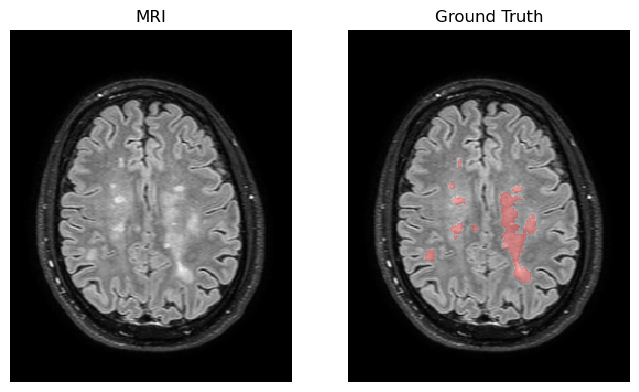

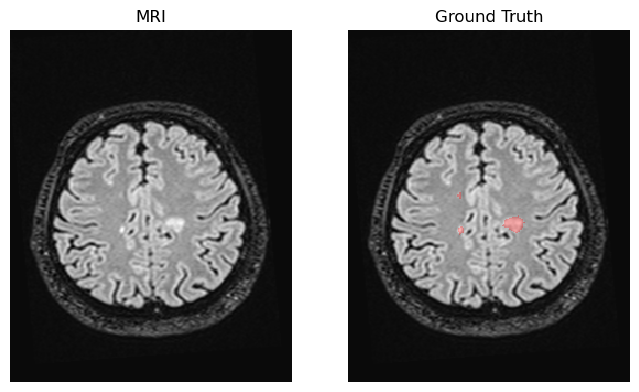

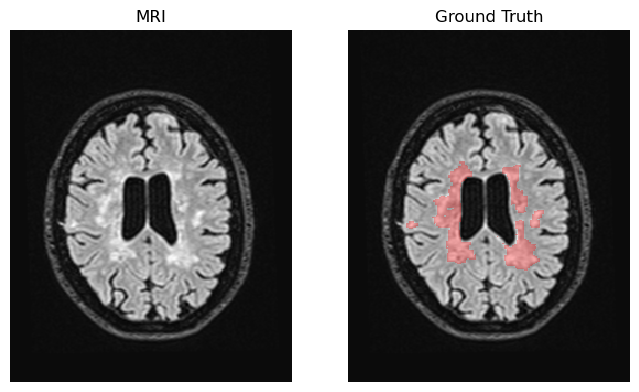

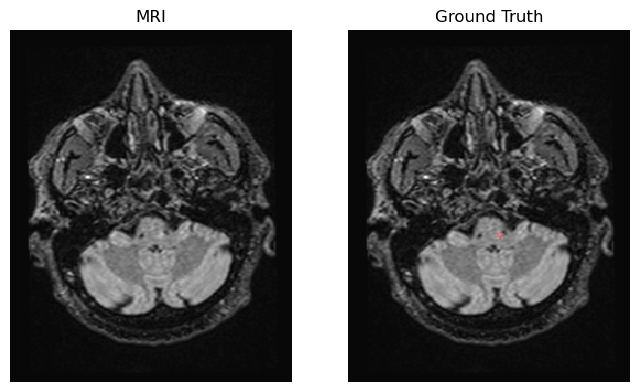

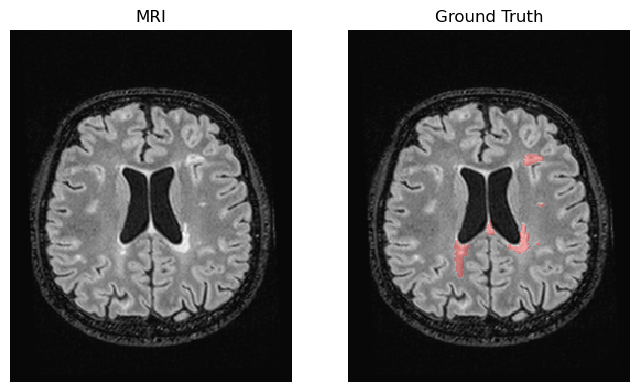

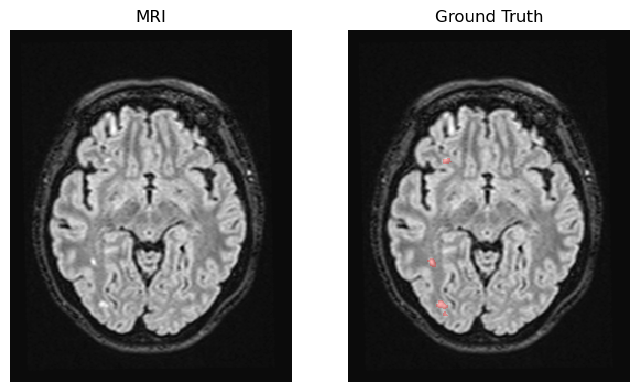

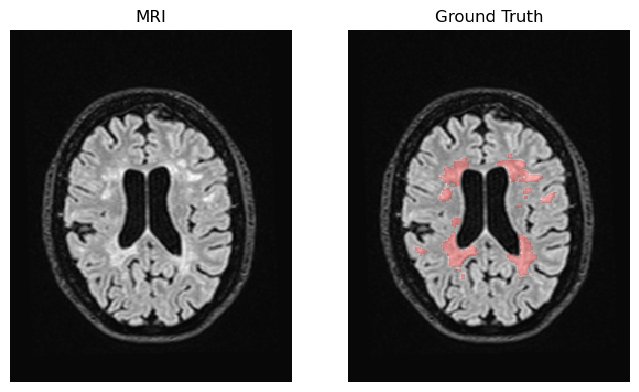

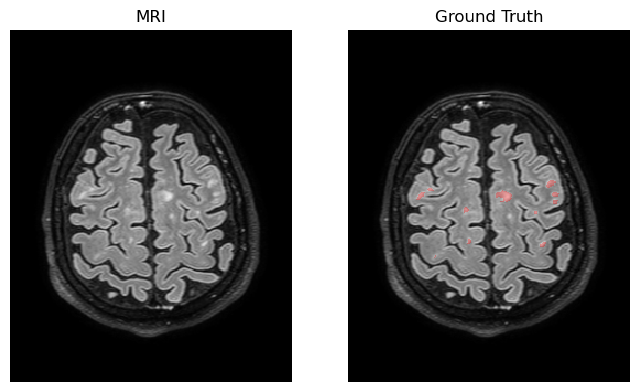

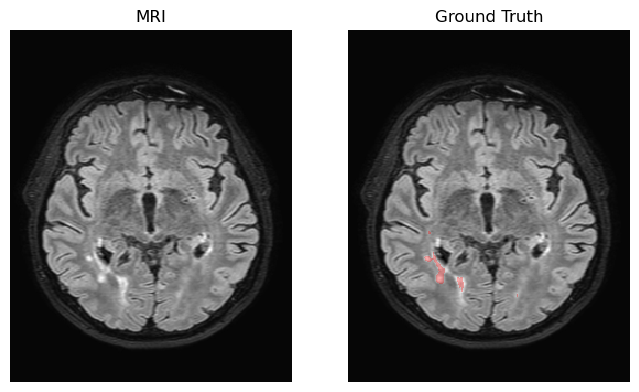

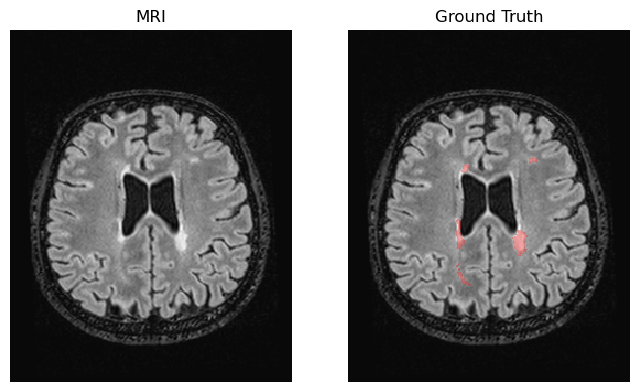

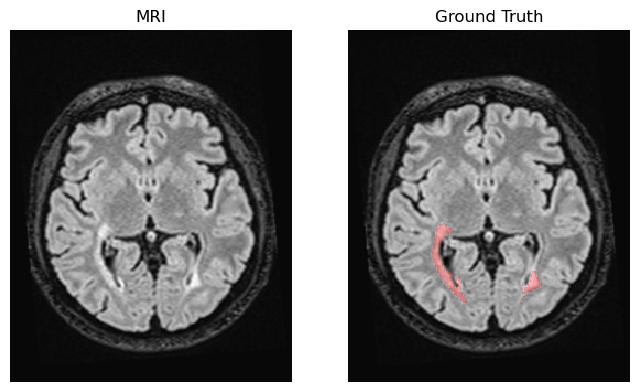

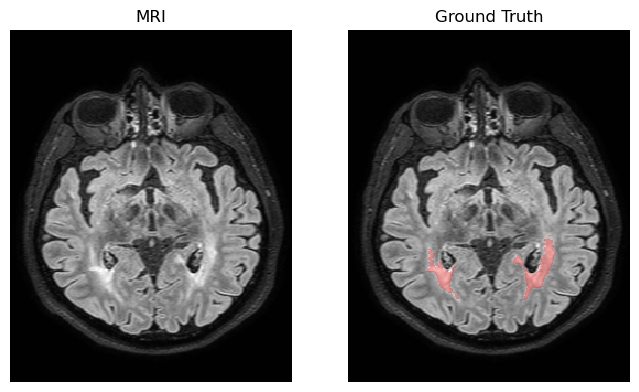

In [16]:
plot_overlay_segmentation(X_test[3:15], y_test[3:15])

## <span style="color:brown"> **3- Load the network and its weights**

In [17]:
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import dice_loss, dice_coef, adaptive_loss
from tensorflow.keras import models

tf.keras.backend.clear_session()

# load the network with its custom functions
loaded_model = models.load_model(model_filename, custom_objects={'dice_coef': dice_coef, 'adaptive_loss': adaptive_loss, 'dice_loss': dice_loss})

# display the network
loaded_model.summary()

2023-05-16 17:48:31.688160: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 17:48:31.688490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-16 17:48:31.689150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-16 17:48:31.689736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 320, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_161 (Conv2D)            (None, 320, 256, 16  160         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_84 (Dropout)           (None, 320, 256, 16  0           ['conv2d_161[0][0]']             
                                )                                                           

## <span style="color:brown"> **4- Predict segmentations on the whole test set using the network**

In [18]:
y_pred = loaded_model.predict(X_test, batch_size=1, verbose=1)

2023-05-16 17:48:35.064739: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-05-16 17:48:35.726833: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-16 17:48:35.727446: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-16 17:48:35.727484: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-05-16 17:48:35.727987: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-16 17:48:35.728052: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


175/175 [==============================] - 4s 5ms/step


In [19]:
loss, dice_coef = loaded_model.evaluate(x=X_test, y=y_test, batch_size=1, verbose=1) # 
print(f"loss : {loss}   dice_coeff : {dice_coef}")

175/175 [==============================] - 1s 6ms/step - loss: 0.0072 - dice_coef: 0.9594
loss : 0.007169031538069248   dice_coeff : 0.9593808650970459


## <span style="color:brown"> 4.1- Plot images : MRI with overlay of ground truth + MRI with prediction overlay

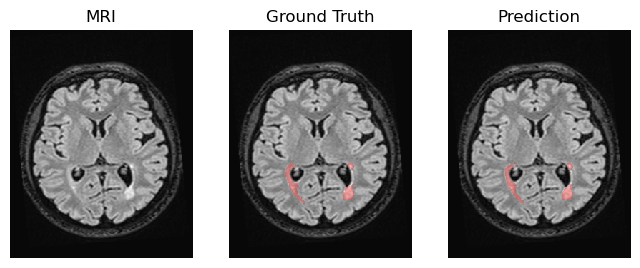

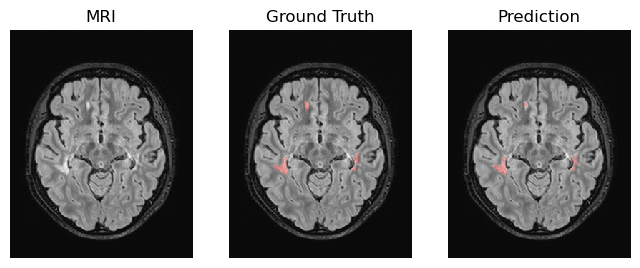

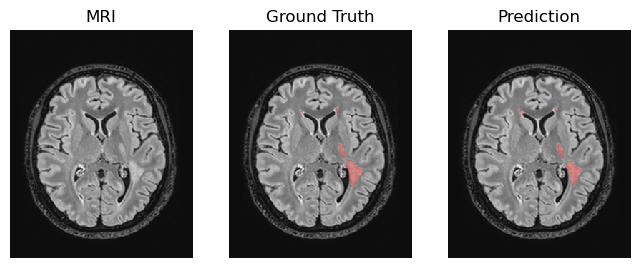

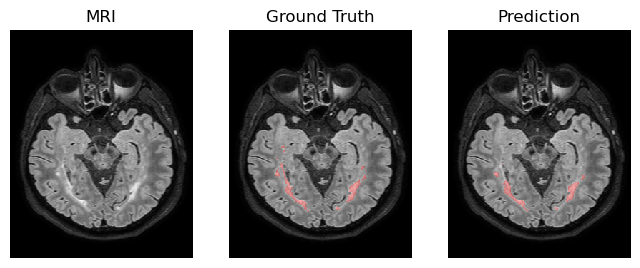

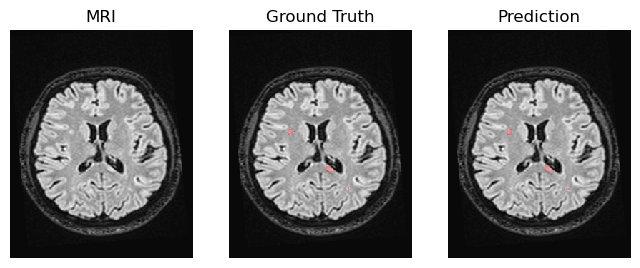

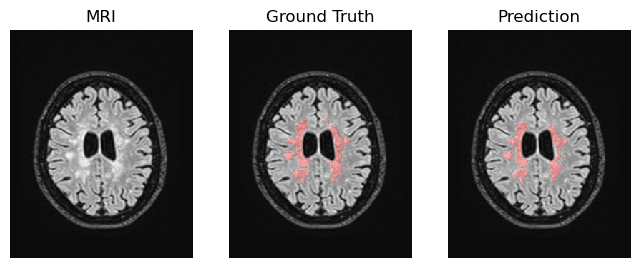

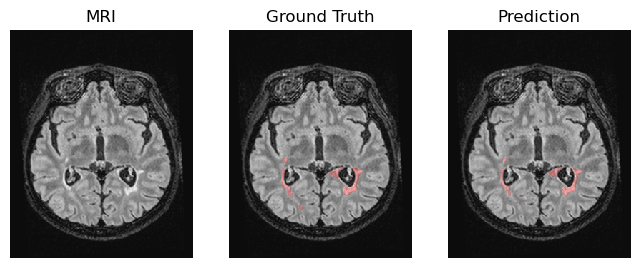

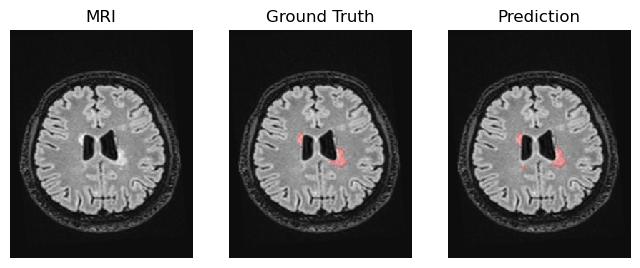

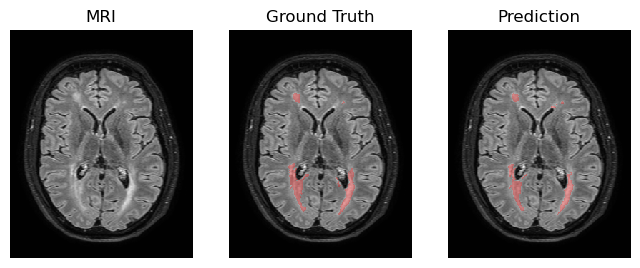

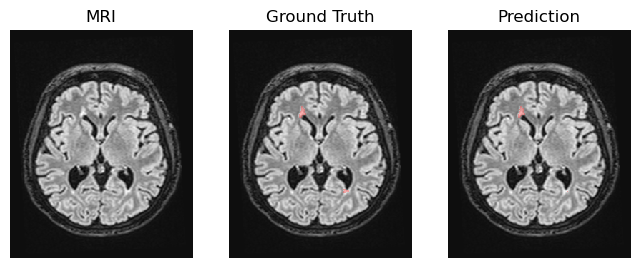

In [21]:
N_b = 20
N_e = 30
plot_compare_segmentation(X_test[N_b:N_e], y_test[N_b:N_e], y_pred[N_b:N_e], " ", spacing=(1,1), step=1)

### <span style="color:red"> Question : </span>

- How the quality of this network is assessed ? what is Dice ?
- Visually consider images and the predictions, what is your qualitative assessment ?


### <span style="color:red"> Question : </span> Importance of 'device'.
- How long was the prediction time (or evaluation time)?
- This step ran on CPU. Now, change the GPU variable (1 -> 0) in the first cell of code and restart the kernel. Then run again the notebook. Compare the evaluate time. 

## <span style="color:brown"> 4.2- Evalaution with DICE/Hausdorff distance and Average symmetric surface distance
    
First, load the code.

In [22]:
from keras_unet.evaluation import  evaluate_segmentation, evaluate_set

Then perform a unique evaluation

In [23]:
#from keras_unet import evaluation
dice, hausdorff, assds = evaluate_segmentation(y_test[1], y_pred[1], voxel_spacing = [1, 1])
print("Dice:", dice)
print("hausdorff:", hausdorff)
print("assds",assds)

Dice: [0.888, 0.888]
hausdorff: [70.40596565632774, 70.40596565632774]
assds [2.0625080316572064, 2.0625080316572064]


Now, on the whole test set 

In [24]:
dice_all, hausdorff_all, assd_all, valid_all = evaluate_set(y_test, y_pred)

100%|██████████| 175/175 [00:03<00:00, 47.65it/s]


In [25]:
print("dice_all", dice_all)
print("hausdorff", hausdorff_all)
print("assd", assd_all)

dice_all [0.8449173 0.8449173]
hausdorff [19.018862 19.018862]
assd [1.6846783 1.6846783]


Improve the rendering for your presentation ;)

,Dice,Hausdorff,ASSD
All,0.845,19.019,1.685
1,0.845,19.019,1.685


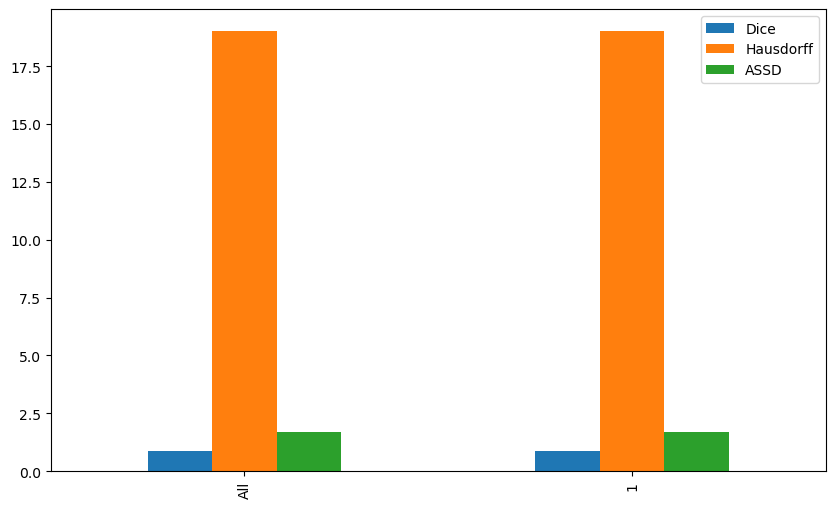

In [27]:
import pandas as pd
from IPython.display import display, HTML 

overall_results = np.column_stack((dice_all, hausdorff_all, assd_all))
#print(overall_results)

# Graft our results matrix into pandas data frames 
overall_results_df = pd.DataFrame(data=overall_results, index = ["All", "1"], 
                                  columns=["Dice", "Hausdorff", "ASSD"]) 

# Display the data as HTML tables and graphs
display(HTML(overall_results_df.to_html(float_format=lambda x: '%.3f' % x)))
overall_results_df.plot(kind='bar', figsize=(10,6)).legend() #bbox_to_anchor=(1.6,0.9))

Or to your paper (latex) :

In [28]:
#print(overall_results_df.to_latex(float_format=lambda x: '%.3f' % x)) # column_format='cccc'

# max Dice value in blod:
latex_tab = overall_results_df.style.highlight_max( props='textbf:--rwrap;', subset=["Dice"])
       
# min "Hausdorff", "ASSD" in bold
latex_tab.highlight_min( props='textbf:--rwrap;', subset=["Hausdorff", "ASSD"])

#limit decimal do different precision
latex_tab.format({
   "Dice": '{:.2f}',
   "Hausdorff": '{:.1f}',
   "ASSD": '{:.3f}'
})  

# generate latex code
print( latex_tab.to_latex(
    column_format="cccc", position="h", position_float="centering",
    hrules=True, label="table:SegmentationResults", caption="Averaged DSC, HD and ASSD on the test set",
    multirow_align="t", multicol_align="r")  )

\begin{table}[h]
\centering
\caption{Averaged DSC, HD and ASSD on the test set}
\label{table:SegmentationResults}
\begin{tabular}{cccc}
\toprule
 & Dice & Hausdorff & ASSD \\
\midrule
All & \textbf{0.84} & \textbf{19.0} & \textbf{1.685} \\
1 & \textbf{0.84} & \textbf{19.0} & \textbf{1.685} \\
\bottomrule
\end{tabular}
\end{table}

